C:\Users\dgulewic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


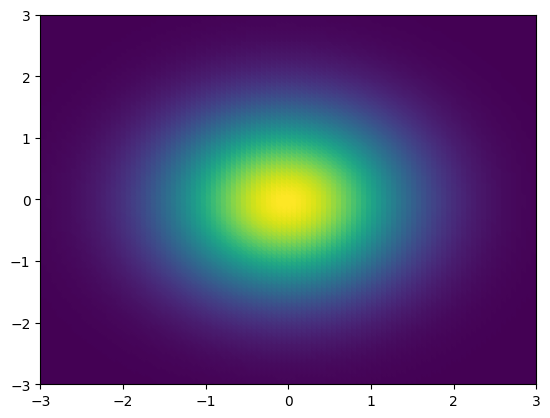

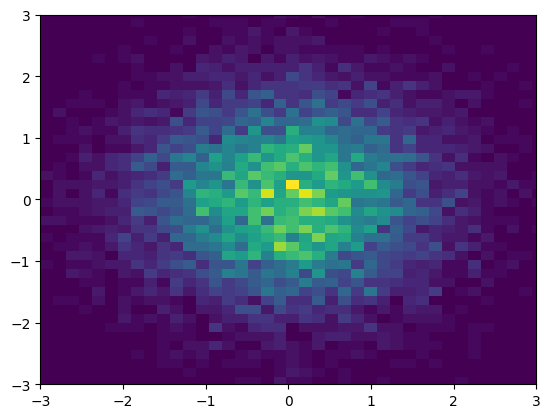

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

## Data via Expression
dn = 100
M = dn**2
N = 10000
range_xy = torch.linspace(start=-3,end=3,steps=dn)
gridx, gridy = torch.meshgrid(range_xy,range_xy)
datax = torch.flatten(gridx)
datay = torch.flatten(gridy)
z0 = torch.stack((datax,datay))

mu = torch.zeros((2,1))
sig = torch.eye(2)
isig = torch.linalg.inv(sig)
dsig = torch.linalg.det(sig)
A = torch.divide(1,2*torch.pi*torch.sqrt(dsig))
B = torch.einsum('ij,ji->i', torch.mul(torch.tensor([-0.5]), (z0-mu).T),torch.matmul(isig,z0-mu))
q0 = torch.mul(A, torch.exp(B))
ln_q0 = torch.log(q0)

## Data via Sampling
mu_func = torch.zeros((1,2))
sig_func = torch.eye(2)
isig_func = torch.linalg.inv(sig_func)
dsig_func = torch.linalg.det(sig_func)

q0_func = torch.distributions.multivariate_normal.MultivariateNormal(mu_func, sig_func)
z0_sample = torch.squeeze(q0_func.sample((N,))).T

A_func = torch.divide(1,2*torch.pi*torch.sqrt(dsig_func))
B_func = torch.einsum('ij,ji->i',torch.mul(torch.tensor([-0.5]),(z0_sample-mu_func.T).T),torch.matmul(isig_func,z0_sample-mu_func.T))
q0_sample = torch.mul(A_func,torch.exp(B_func))
ln_q0_sample = torch.log(q0_sample)

# Data via Expression
plt.figure(101)
plt.scatter(datax,datay,c=q0)
plt.xlim([-3,3])
plt.ylim([-3,3])

# Data via Sampling
plt.figure(102)
plt.hist2d(z0_sample[0,:],z0_sample[1,:], bins=50)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

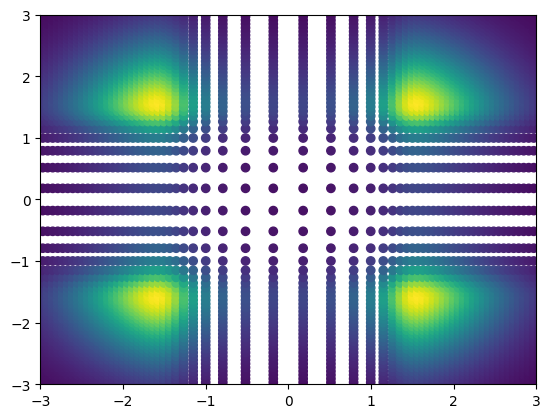

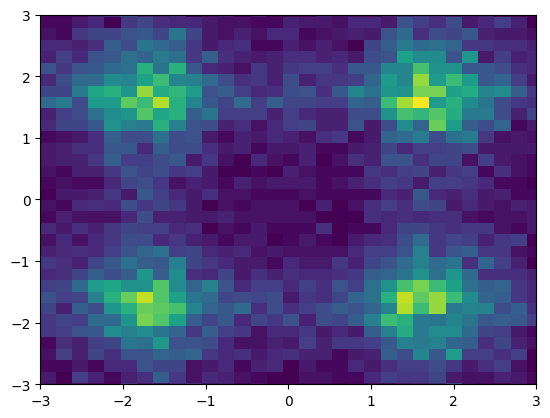

In [2]:
# Example Parameters
w1 = torch.Tensor([[5.0,0.0]])
b1 = torch.Tensor([0.0])
u1 = torch.Tensor([[1.0,0.0]])

w2 = torch.Tensor([[0.0,5.0]])
b2 = torch.Tensor([0.0])
u2 = torch.Tensor([[0.0,1.0]])

# Jacobian Transformation Gridded
h = torch.tanh(torch.matmul(w1,z0) + b1)
hp = 1-torch.pow(h,2)
detJ = torch.abs(1 + torch.mul(torch.matmul(w1,u1.T),hp))
ln_q_z1 = torch.log(detJ)
z1_jac = z0 + torch.matmul(u1.T,h)
q1_jac = torch.exp(ln_q0 - ln_q_z1)

h = torch.tanh(torch.matmul(w2,z1_jac) + b2)
hp = 1-torch.pow(h,2)
detJ = torch.abs(1 + torch.mul(torch.matmul(w2,u2.T),hp))
ln_q_z2 = torch.log(detJ)
z2_jac = z1_jac + torch.matmul(u2.T,h)
q2_jac = torch.exp(ln_q0 - ln_q_z1 - ln_q_z2)
ln_q2_jac = torch.log(q2_jac)

z1x_jac_mean = torch.sum(torch.matmul(q2_jac.reshape((1,N)),z2_jac[0,:]))/M
z2x_jac_mean = torch.sum(torch.matmul(q2_jac.reshape((1,N)), z2_jac[1,:]))/M

z1x_jac_var = torch.sum(torch.pow(z2_jac[0,:] - z1x_jac_mean,2))/M
z2x_jac_var = torch.sum(torch.pow(z2_jac[1,:] - z2x_jac_mean,2))/M

# Sampling Transformation
h = torch.tanh(torch.matmul(w1,z0_sample) + b1)
hp = 1-torch.pow(h,2)
detJ = torch.abs(1 + torch.mul(torch.matmul(w1,u1.T),hp))
ln_q_z1 = torch.log(detJ)
z1_sam = z0_sample + torch.matmul(u1.T,h)
q1_sam = torch.exp(ln_q0 - ln_q_z1)

h = torch.tanh(torch.matmul(w2,z1_sam) + b2)
hp = 1-torch.pow(h,2)
detJ = torch.abs(1 + torch.mul(torch.matmul(w2,u2.T),hp))
ln_q_z2 = torch.log(detJ)
z2_sam = z1_sam + torch.matmul(u2.T,h)
q2_sam = torch.exp(ln_q0 - ln_q_z1 - ln_q_z2)

z1x_sam_mean = torch.sum(torch.matmul(q2_sam.reshape((1,N)),z2_sam[0,:]))/N
z2x_sam_mean = torch.sum(torch.matmul(q2_sam.reshape((1,N)), z2_sam[1,:]))/N

z1x_sam_var = torch.sum(torch.pow(z2_sam[0,:] - z1x_sam_mean,2))/N
z2x_sam_var = torch.sum(torch.pow(z2_sam[1,:] - z2x_sam_mean,2))/N

# PDF via Jacobian
plt.figure(103)
plt.scatter(z2_jac[0,:],z2_jac[1,:],c=q2_jac)
plt.xlim([-3,3])
plt.ylim([-3,3])

# PDF via Sampling
plt.figure(104)
plt.hist2d(z2_sam[0,:],z2_sam[1,:], bins=50)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

In [3]:
## Create Single Layer of Discrete Normalizing Flow
class Planar_Layer(torch.nn.Module):
    def __init__(self,d):
        super(Planar_Layer,self).__init__()
        self.u = torch.nn.Parameter(torch.Tensor(1, d), requires_grad=True)
        self.w = torch.nn.Parameter(torch.Tensor(1, d), requires_grad=True)
        self.b = torch.nn.Parameter(torch.Tensor(1), requires_grad=True)
        self.init_params()

    def init_params(self):
        self.w.data.uniform_(0, 0.01)
        self.b.data.uniform_(0, 0.01)
        self.u.data.uniform_(0, 0.01)
        
    def forward(self, z):         
        h = torch.tanh(torch.matmul(self.w,z) + self.b)
        hp = 1-torch.pow(h,2)
        detJ = 1 + torch.mul(torch.matmul(self.w,self.u.T),hp)
        ln_q_zL = torch.log(torch.abs(detJ)+1e-7)
        zL = torch.add(z, torch.matmul(self.u.T,h))
        
        if torch.matmul(self.w,self.u.T) < -1:
            print("uh oh")
        
        return zL, ln_q_zL
    
## Create Discrete Normalizing Flows Class
class DNF(torch.nn.Module): # torch only tracks parameters with autograd when requires_grad=True
    def __init__(self,d,L):
        super(DNF,self).__init__()
        self.layers = torch.nn.ModuleList([Planar_Layer(d) for _ in range(L)])
        
    def forward(self, x): # forward is a required part, this defines what to do in the forward pass of the nn, automatically
        sigma_ln_q_zL = 0
               
        for layer in self.layers:
            x, ln_q_zL = layer(x)
            sigma_ln_q_zL = sigma_ln_q_zL + ln_q_zL
            
        return x, sigma_ln_q_zL

In [4]:
## Define NN Hyper-Parameters
d = 2         # dimension of input data
L = 2         # HYPERPARAMETER: number of sequencial layers
a = 0.005     # HYPERPARAMETER: Learning Rate
theta = 0.9   # HYPERPARAMETER: Momentum Coefficient
e = 20000    # HYPERPARAMETER: Number of epochs

model = DNF(d,L)
optimizer = torch.optim.Adam(params=model.parameters(),lr=a)
loss_vec = torch.zeros((e,1))
model.train()                  # this command tells pytorch to track gradients

for i in range(e):
    optimizer.zero_grad()           # zero out gradients for all model parameters, value is accumulated not replaced!   
    zL, ln_q_zL = model(z0)         # do forward propogation
    ln_qn_pred = ln_q0 - ln_q_zL    # Compute log probability density after transformation
    qn_pred = torch.exp(ln_qn_pred) # Compute probability after transformation
    
    z1x_jacimp_mean = torch.sum(torch.matmul(qn_pred.reshape((1,N)),zL[0,:]))/M 
    z2x_jacimp_mean = torch.sum(torch.matmul(qn_pred.reshape((1,N)),zL[1,:]))/M
    
    z1x_jacimp_var = torch.sum(torch.pow(zL[0,:] - z1x_jacimp_mean,2))/M
    z2x_jacimp_var = torch.sum(torch.pow(zL[1,:] - z2x_jacimp_mean,2))/M

    loss = 10*torch.sum(torch.mul(q2_jac,torch.abs(ln_q2_jac - ln_qn_pred))) + (z1x_jacimp_var - z1x_jac_var)**2 + (z2x_jacimp_var - z2x_jac_var)**2
    loss_vec[i] = loss.data
    
    if np.isnan(loss_vec[i]):
        print(i)
    
    loss.backward()           # update gradients for each model parameter 
    optimizer.step()          # update each model parameter using gradient descent  

In [5]:
# Show Identified Parameters
for p in model.parameters():
    if p.requires_grad:
         print(p.name, p.data)

None tensor([[ 5.1670e-04, -1.0001e+00]])
None tensor([[ 1.2359e-04, -4.9999e+00]])
None tensor([0.0005])
None tensor([[ 0.9996, -0.0083]])
None tensor([[ 5.0010e+00, -2.5264e-04]])
None tensor([0.0002])


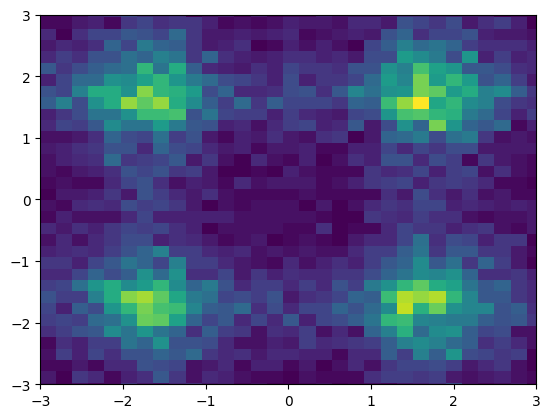

tensor([0.7343])


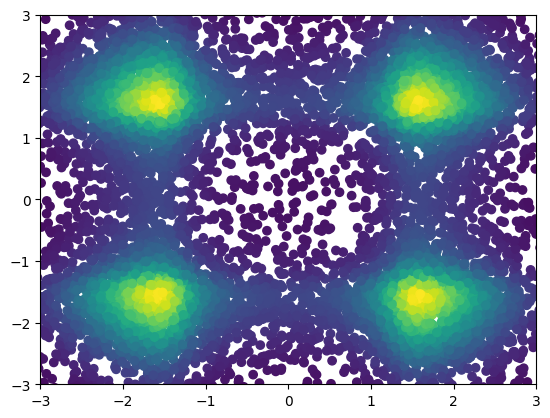

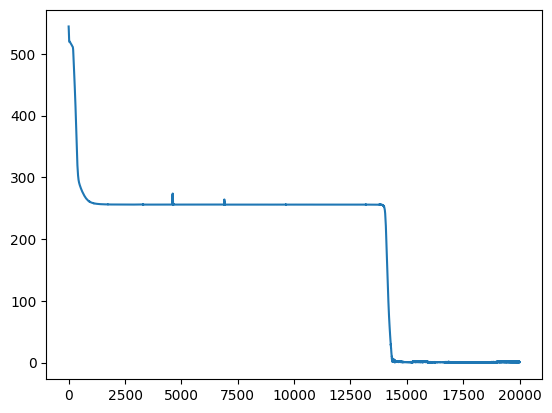

In [6]:
# Compute Model Outputs
model.eval()
zL, ln_q_zL = model(z0_sample)
ln_qn_pred = ln_q0_sample - ln_q_zL   # Compute log probability density after transformation

# PDF via Sampling
plt.figure(106)
plt.hist2d(zL[0,:].data.numpy(),zL[1,:].data.numpy(), bins=50)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

# PDF via Jacobian
plt.figure(107)
plt.scatter(zL[0,:].detach().numpy(),zL[1,:].detach().numpy(),c=torch.exp(ln_qn_pred).detach().numpy())
plt.xlim([-3,3])
plt.ylim([-3,3])

plt.figure(108)
plt.plot(range(e),loss_vec.data)

print(loss_vec[-1])